### timeseries of biological and environmental variables from CESM2-4p2z model run

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import os
from glob import glob
from collections import OrderedDict
import xarray as xr
import numpy as np

import ncar_jobqueue
from dask.distributed import Client
import esmlab
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from scipy import stats
import pop_tools 
import pandas as pd
import cftime
import matplotlib.colors as colors
import utils

In [2]:
case = 'g.e22.GOMIPECOIAF_JRA-1p4-2018.TL319_g17.4p2z.002branch'
obs_dir = '/glade/campaign/cesm/development/bgcwg/projects/CESM2-OMIP2-like-4p2z-run/' + case + '/ocn/proc/tseries/month_1/'

###  grab desired variables

In [3]:
variables = ['PH','SHF_QSW','DIC','NO3','TEMP',
             'HMXL','coccoC','coccoCaCO3','diatC',
             'spC','diatSi','Fe','cocco_Fe_lim_Cweight_avg_100m','IRON_FLUX']

### define the data range

In [4]:
ds_fosi = xr.Dataset()
#ds_fosi_seas = xr.Dataset()

for var in variables:
    
    print('starting on ', var)
    ################ FOSI
    
    ds_tmp = xr.open_dataset(obs_dir + case + '.pop.h.' + var + '.195801-202112.nc')
    
    keep_vars=['z_t','z_t_150m','time_bound','dz','TLAT','TLONG','time'] + [var]

    ds_tmp = ds_tmp.drop([v for v in ds_tmp.variables if v not in keep_vars])
    
    ds_fosi = xr.merge([ds_fosi,ds_tmp],combine_attrs='override')

starting on  PH
starting on  SHF_QSW
starting on  DIC
starting on  NO3
starting on  TEMP
starting on  HMXL
starting on  coccoC
starting on  coccoCaCO3
starting on  diatC
starting on  spC
starting on  diatSi
starting on  Fe
starting on  cocco_Fe_lim_Cweight_avg_100m
starting on  IRON_FLUX


In [5]:
def get_ClusterClient():
    import dask
    from dask_jobqueue import PBSCluster
    from dask.distributed import Client
    cluster = PBSCluster(
        cores=2,
        memory='25 GB',
        processes=1,
        queue='casper',
        resource_spec='select=1:ncpus=1:mem=25GB',
        project='NCGD0011',
        walltime='05:00:00',
        interface='ext',)

    dask.config.set({
        'distributed.dashboard.link':
        'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'
    })
    client = Client(cluster)
    return cluster, client

In [6]:
cluster, client = get_ClusterClient()
cluster.scale(12) 
client

Client Scheduler: tcp://128.117.208.110:43867 Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kristenk/proxy/8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


### Integrate phytoplankton vars

In [7]:
attrs = ds_fosi['diatC'].attrs
ds_fosi['diatC']= (ds_fosi['diatC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['diatC'].attrs = attrs
ds_fosi['diatC'].attrs['units'] = 'mmol/m^2'
        
attrs = ds_fosi['coccoC'].attrs
ds_fosi['coccoC']= (ds_fosi['coccoC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['coccoC'].attrs = attrs
ds_fosi['coccoC'].attrs['units'] = 'mmol/m^2'

attrs = ds_fosi['coccoCaCO3'].attrs
ds_fosi['coccoCaCO3']= (ds_fosi['coccoCaCO3'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['coccoCaCO3'].attrs = attrs
ds_fosi['coccoCaCO3'].attrs['units'] = 'mmol/m^2'

attrs = ds_fosi['diatSi'].attrs
ds_fosi['diatSi']= (ds_fosi['diatSi'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['diatSi'].attrs = attrs
ds_fosi['diatSi'].attrs['units'] = 'mmol/m^2'

attrs = ds_fosi['spC'].attrs
ds_fosi['spC']= (ds_fosi['spC'].isel(z_t_150m=slice(0,10))*10.).sum(dim='z_t_150m')
ds_fosi['spC'].attrs = attrs
ds_fosi['spC'].attrs['units'] = 'mmol/m^2'

### make top 100m of environmental variables

In [8]:
%%time

attrs = ds_fosi['TEMP'].attrs
ds_fosi['TEMP']= (ds_fosi['TEMP'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['TEMP'].attrs = attrs
ds_fosi['TEMP'].attrs['long_name'] = 'top 100 m mean temperature'

print('temp done')

attrs = ds_fosi['DIC'].attrs
ds_fosi['DIC']= (ds_fosi['DIC'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['DIC'].attrs = attrs
ds_fosi['DIC'].attrs['long_name'] = 'top 100 m mean dissolved inorganic carbon'

print('dic done')

attrs = ds_fosi['Fe'].attrs
ds_fosi['Fe']= (ds_fosi['Fe'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['Fe'].attrs = attrs
ds_fosi['Fe'].attrs['long_name'] = 'top 100 m mean dissolved inorganic iron'

print('fe done')

attrs = ds_fosi['NO3'].attrs
ds_fosi['NO3']= (ds_fosi['NO3'].isel(z_t=slice(0,10))).mean(dim='z_t') # top 100m mean
ds_fosi['NO3'].attrs = attrs
ds_fosi['NO3'].attrs['long_name'] = 'top 100 m mean dissolved inorganic nitrate'

temp done
dic done
fe done
CPU times: user 5min 21s, sys: 35.7 s, total: 5min 57s
Wall time: 6min 12s


### get coords and make a ones array for masking

In [9]:
ds_grid = pop_tools.get_grid('POP_gx1v7')
lats = ds_grid.TLAT
lons = ds_grid.TLONG
area = ds_grid.TAREA
area_m = area * 1.e-4
area_km = area * 1.e-10
lons_norm = utils.normal_lons(lons)

In [10]:
ones = np.full((384,320),1,dtype=int)
ones = xr.DataArray(ones,dims=('nlat','nlon'))
ones = ones.where(ds_grid.REGION_MASK>0)

In [11]:
#ds_fosi_seas = ds_fosi_seas.where(ds_grid.REGION_MASK>0)

### Create mineral/organic carbon ratio for coccolithophores and diatoms

In [12]:
#ds_fosi_seas['picpoc'] = ds_fosi_seas.coccoCaCO3/ds_fosi_seas.coccoC
ds_fosi['picpoc'] = ds_fosi.coccoCaCO3/ds_fosi.coccoC
ds_fosi['picpoc'].attrs = ds_fosi.coccoCaCO3.attrs
ds_fosi['picpoc'].attrs['long_name'] = 'coccolithophore picpoc ratio'
ds_fosi['picpoc'].attrs['units'] = 'ratio'

#ds_fosi_seas['diatSi_to_C'] = ds_fosi_seas.diatSi/ds_fosi_seas.diatC
ds_fosi['diatSi_to_C'] =  ds_fosi.diatSi/ds_fosi.diatC
ds_fosi['diatSi_to_C'].attrs = ds_fosi.diatSi.attrs
ds_fosi['diatSi_to_C'].attrs['long_name'] = 'diatom Si/C ratio'
ds_fosi['diatSi_to_C'].attrs['units'] = 'ratio'

variables = variables + ['picpoc','diatSi_to_C']

In [13]:
ds_fosi["time"] = ds_fosi.time_bound.compute().mean(dim="d2")

In [14]:
ds_fosi.time

<xarray.DataArray 'time' (time: 768)>
array([cftime.DatetimeNoLeap(1958, 1, 16, 13, 0, 0, 1),
       cftime.DatetimeNoLeap(1958, 2, 15, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(1958, 3, 16, 12, 0, 0, 0), ...,
       cftime.DatetimeNoLeap(2021, 10, 16, 12, 0, 0, 0),
       cftime.DatetimeNoLeap(2021, 11, 16, 0, 0, 0, 0),
       cftime.DatetimeNoLeap(2021, 12, 16, 12, 0, 0, 0)], dtype=object)
Coordinates:
  * time     (time) object 1958-01-16 13:00:00.000001 ... 2021-12-16 12:00:00
Attributes:
    long_name:     boundaries for time-averaging interval
    cell_methods:  time: mean

### Put months into a dict

In [15]:
ds_by_mon_dict = {}
ds_by_mon_dict['dec'] = ds_fosi.sel(time = np.in1d(ds_fosi['time.month'], 12))
ds_by_mon_dict['jan'] = ds_fosi.sel(time = np.in1d(ds_fosi['time.month'], 1))
ds_by_mon_dict['feb'] = ds_fosi.sel(time = np.in1d(ds_fosi['time.month'], 2))

ds_by_mon_dict['nov'] = ds_fosi.sel(time = np.in1d(ds_fosi['time.month'], 11))
ds_by_mon_dict['oct'] = ds_fosi.sel(time = np.in1d(ds_fosi['time.month'], 10))
ds_by_mon_dict['mar'] = ds_fosi.sel(time = np.in1d(ds_fosi['time.month'], 3))

In [16]:
ds_by_mon_dict['oct']['time'] = np.arange(1958,2022,1)
ds_by_mon_dict['nov']['time'] = np.arange(1958,2022,1)
ds_by_mon_dict['dec']['time'] = np.arange(1958,2022,1)
ds_by_mon_dict['jan']['time'] = np.arange(1958,2022,1)
ds_by_mon_dict['feb']['time'] = np.arange(1958,2022,1)
ds_by_mon_dict['mar']['time'] = np.arange(1958,2022,1)

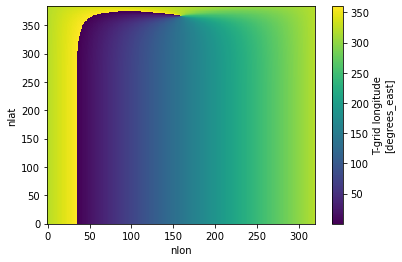

In [17]:
lons.plot()

#### these may need to be refined

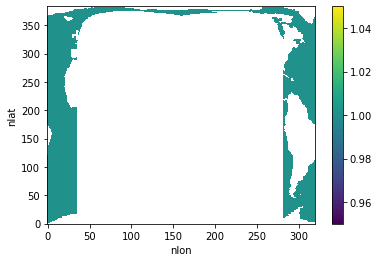

In [18]:
mask_transect_reg1 = ones.where(lons>277).where(lons<359)
mask_transect_reg1.plot()

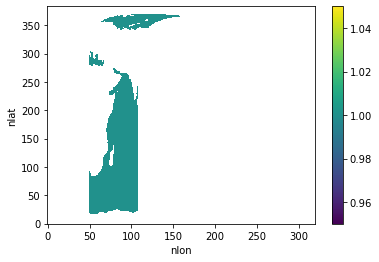

In [19]:
mask_transect_reg2 = ones.where(lons>15.7).where(lons<82)
mask_transect_reg2.plot()

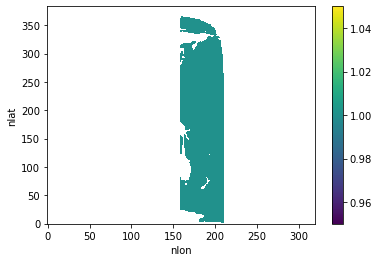

In [20]:
mask_transect_reg3 = ones.where(lons>137.2).where(lons<197)
mask_transect_reg3.plot()

In [21]:
%%time

ts_by_mon_dict_reg1 = {}
ts_by_mon_dict_reg2 = {}
ts_by_mon_dict_reg3 = {}

for mon in ['oct','nov','dec','jan','feb','mar']:
    print(mon)
    ds_tmp1 = xr.Dataset()
    ds_tmp2 = xr.Dataset()
    ds_tmp3 = xr.Dataset()
    
    for v in variables: #transect_vars:
        
        ds_tmp1[v] = esmlab.statistics.weighted_mean(ds_by_mon_dict[mon][v].where(mask_transect_reg1==1), weights=area, dim=['nlon'])
        ds_tmp1[v].attrs = ds_fosi[v].attrs
        
        ds_tmp2[v] = esmlab.statistics.weighted_mean(ds_by_mon_dict[mon][v].where(mask_transect_reg2==1), weights=area, dim=['nlon'])
        ds_tmp2[v].attrs = ds_fosi[v].attrs
        
        ds_tmp3[v] = esmlab.statistics.weighted_mean(ds_by_mon_dict[mon][v].where(mask_transect_reg3==1), weights=area, dim=['nlon'])
        ds_tmp3[v].attrs = ds_fosi[v].attrs
            
    ts_by_mon_dict_reg1[mon] = ds_tmp1
    ts_by_mon_dict_reg2[mon] = ds_tmp2
    ts_by_mon_dict_reg3[mon] = ds_tmp3
    
    ts_by_mon_dict_reg1[mon] = ts_by_mon_dict_reg1[mon].load()
    ts_by_mon_dict_reg2[mon] = ts_by_mon_dict_reg2[mon].load()
    ts_by_mon_dict_reg3[mon] = ts_by_mon_dict_reg3[mon].load()

oct
nov
dec
jan
feb
mar
CPU times: user 4min 4s, sys: 18.2 s, total: 4min 22s
Wall time: 4min 44s


In [22]:
# REGION 1 - low

lo_cocco_oct = ts_by_mon_dict_reg1['oct'].sel(time=[1964, 1969, 1970, 1973, 1974, 1980, 1983, 1984, 1999, 2001]).mean(dim='time')
lo_cocco_nov = ts_by_mon_dict_reg1['nov'].sel(time=[1964, 1969, 1970, 1973, 1974, 1980, 1983, 1984, 1999, 2001]).mean(dim='time')
lo_cocco_dec = ts_by_mon_dict_reg1['dec'].sel(time=[1964, 1969, 1970, 1973, 1974, 1980, 1983, 1984, 1999, 2001]).mean(dim='time')

# the year after the year in the figure
lo_cocco_jan = ts_by_mon_dict_reg1['jan'].sel(time=[1965, 1970, 1971, 1974, 1975, 1981, 1984, 1985, 2000, 2002]).mean(dim='time')
lo_cocco_feb = ts_by_mon_dict_reg1['feb'].sel(time=[1965, 1970, 1971, 1974, 1975, 1981, 1984, 1985, 2000, 2002]).mean(dim='time')
lo_cocco_mar = ts_by_mon_dict_reg1['mar'].sel(time=[1965, 1970, 1971, 1974, 1975, 1981, 1984, 1985, 2000, 2002]).mean(dim='time')

lo_cocco_ts_reg1 = xr.concat([lo_cocco_oct,lo_cocco_nov,lo_cocco_dec,lo_cocco_jan,lo_cocco_feb,lo_cocco_mar],dim='time')

In [23]:
# REGION 1 - hi

hi_cocco_oct = ts_by_mon_dict_reg1['oct'].sel(time=[1968, 1972, 1979, 1991, 1992, 2000, 2005, 2009, 2012, 2017, 2018]).mean(dim='time')
hi_cocco_nov = ts_by_mon_dict_reg1['nov'].sel(time=[1968, 1972, 1979, 1991, 1992, 2000, 2005, 2009, 2012, 2017, 2018]).mean(dim='time')
hi_cocco_dec = ts_by_mon_dict_reg1['dec'].sel(time=[1968, 1972, 1979, 1991, 1992, 2000, 2005, 2009, 2012, 2017, 2018]).mean(dim='time')

# the year after the year in the figure
hi_cocco_jan = ts_by_mon_dict_reg1['jan'].sel(time=[1969, 1973, 1980, 1992, 1993, 2001, 2006, 2010, 2013, 2018, 2019]).mean(dim='time')
hi_cocco_feb = ts_by_mon_dict_reg1['feb'].sel(time=[1969, 1973, 1980, 1992, 1993, 2001, 2006, 2010, 2013, 2018, 2019]).mean(dim='time')
hi_cocco_mar = ts_by_mon_dict_reg1['mar'].sel(time=[1969, 1973, 1980, 1992, 1993, 2001, 2006, 2010, 2013, 2018, 2019]).mean(dim='time')

hi_cocco_ts_reg1 = xr.concat([hi_cocco_oct,hi_cocco_nov,hi_cocco_dec,hi_cocco_jan,hi_cocco_feb,hi_cocco_mar],dim='time')

In [24]:
# REGION 2 - low

lo_cocco_oct = ts_by_mon_dict_reg2['oct'].sel(time=[1958, 1961, 1964, 1967, 1981, 1991, 1996, 1997, 2020]).mean(dim='time')
lo_cocco_nov = ts_by_mon_dict_reg2['nov'].sel(time=[1958, 1961, 1964, 1967, 1981, 1991, 1996, 1997, 2020]).mean(dim='time')
lo_cocco_dec = ts_by_mon_dict_reg2['dec'].sel(time=[1958, 1961, 1964, 1967, 1981, 1991, 1996, 1997, 2020]).mean(dim='time')

# the year after the year in the figure
lo_cocco_jan = ts_by_mon_dict_reg2['jan'].sel(time=[1959, 1962, 1965, 1968, 1982, 1992, 1997, 1998, 2021]).mean(dim='time')
lo_cocco_feb = ts_by_mon_dict_reg2['feb'].sel(time=[1959, 1962, 1965, 1968, 1982, 1992, 1997, 1998, 2021]).mean(dim='time')
lo_cocco_mar = ts_by_mon_dict_reg2['mar'].sel(time=[1959, 1962, 1965, 1968, 1982, 1992, 1997, 1998, 2021]).mean(dim='time')

lo_cocco_ts_reg2 = xr.concat([lo_cocco_oct,lo_cocco_nov,lo_cocco_dec,lo_cocco_jan,lo_cocco_feb,lo_cocco_mar],dim='time')

In [25]:
# REGION 2 - hi

hi_cocco_oct = ts_by_mon_dict_reg2['oct'].sel(time=[1972, 1974, 1978, 1992, 1995, 2001, 2002, 2004, 2006, 2007, 2013, 2015]).mean(dim='time')
hi_cocco_nov = ts_by_mon_dict_reg2['nov'].sel(time=[1972, 1974, 1978, 1992, 1995, 2001, 2002, 2004, 2006, 2007, 2013, 2015]).mean(dim='time')
hi_cocco_dec = ts_by_mon_dict_reg2['dec'].sel(time=[1972, 1974, 1978, 1992, 1995, 2001, 2002, 2004, 2006, 2007, 2013, 2015]).mean(dim='time')

# the year after the year in the figure
hi_cocco_jan = ts_by_mon_dict_reg2['jan'].sel(time=[1973, 1975, 1979, 1993, 1996, 2002, 2003, 2005, 2007, 2008, 2014, 2016]).mean(dim='time')
hi_cocco_feb = ts_by_mon_dict_reg2['feb'].sel(time=[1973, 1975, 1979, 1993, 1996, 2002, 2003, 2005, 2007, 2008, 2014, 2016]).mean(dim='time')
hi_cocco_mar = ts_by_mon_dict_reg2['mar'].sel(time=[1973, 1975, 1979, 1993, 1996, 2002, 2003, 2005, 2007, 2008, 2014, 2016]).mean(dim='time')

hi_cocco_ts_reg2 = xr.concat([hi_cocco_oct,hi_cocco_nov,hi_cocco_dec,hi_cocco_jan,hi_cocco_feb,hi_cocco_mar],dim='time')

In [26]:
# REGION 3 - low

lo_cocco_oct = ts_by_mon_dict_reg3['oct'].sel(time=[1974, 1980, 1981, 1984, 1988, 1992, 2000, 2002, 2007, 2017]).mean(dim='time')
lo_cocco_nov = ts_by_mon_dict_reg3['nov'].sel(time=[1974, 1980, 1981, 1984, 1988, 1992, 2000, 2002, 2007, 2017]).mean(dim='time')
lo_cocco_dec = ts_by_mon_dict_reg3['dec'].sel(time=[1974, 1980, 1981, 1984, 1988, 1992, 2000, 2002, 2007, 2017]).mean(dim='time')

# the year after the year in the figure
lo_cocco_jan = ts_by_mon_dict_reg3['jan'].sel(time=[1975, 1981, 1982, 1985, 1989, 1993, 2001, 2003, 2008, 2018]).mean(dim='time')
lo_cocco_feb = ts_by_mon_dict_reg3['feb'].sel(time=[1975, 1981, 1982, 1985, 1989, 1993, 2001, 2003, 2008, 2018]).mean(dim='time')
lo_cocco_mar = ts_by_mon_dict_reg3['mar'].sel(time=[1975, 1981, 1982, 1985, 1989, 1993, 2001, 2003, 2008, 2018]).mean(dim='time')

lo_cocco_ts_reg3 = xr.concat([lo_cocco_oct,lo_cocco_nov,lo_cocco_dec,lo_cocco_jan,lo_cocco_feb,lo_cocco_mar],dim='time')

In [27]:
# REGION 3 - hi

hi_cocco_oct = ts_by_mon_dict_reg3['oct'].sel(time=[1965, 1967, 1972, 1975, 1977, 1990, 2006, 2011, 2014, 2020]).mean(dim='time')
hi_cocco_nov = ts_by_mon_dict_reg3['nov'].sel(time=[1965, 1967, 1972, 1975, 1977, 1990, 2006, 2011, 2014, 2020]).mean(dim='time')
hi_cocco_dec = ts_by_mon_dict_reg3['dec'].sel(time=[1965, 1967, 1972, 1975, 1977, 1990, 2006, 2011, 2014, 2020]).mean(dim='time')

# the year after the year in the figure
hi_cocco_jan = ts_by_mon_dict_reg3['jan'].sel(time=[1966, 1968, 1973, 1976, 1978, 1991, 2007, 2012, 2015, 2021]).mean(dim='time')
hi_cocco_feb = ts_by_mon_dict_reg3['feb'].sel(time=[1966, 1968, 1973, 1976, 1978, 1991, 2007, 2012, 2015, 2021]).mean(dim='time')
hi_cocco_mar = ts_by_mon_dict_reg3['mar'].sel(time=[1966, 1968, 1973, 1976, 1978, 1991, 2007, 2012, 2015, 2021]).mean(dim='time')

hi_cocco_ts_reg3 = xr.concat([hi_cocco_oct,hi_cocco_nov,hi_cocco_dec,hi_cocco_jan,hi_cocco_feb,hi_cocco_mar],dim='time')

In [28]:
v = 'TLAT'

lats_transect_reg1 = esmlab.statistics.weighted_mean(ds_grid[v].where(mask_transect_reg1==1), weights=area, dim=['nlon'])
lats_transect_reg2 = esmlab.statistics.weighted_mean(ds_grid[v].where(mask_transect_reg2==1), weights=area, dim=['nlon'])
lats_transect_reg3 = esmlab.statistics.weighted_mean(ds_grid[v].where(mask_transect_reg3==1), weights=area, dim=['nlon'])

In [29]:
lats_trimmed_reg1 = lats_transect_reg1.where(lats_transect_reg1<-30,drop=True)
lats_trimmed_reg2 = lats_transect_reg2.where(lats_transect_reg2<-30,drop=True)
lats_trimmed_reg3 = lats_transect_reg3.where(lats_transect_reg3<-30,drop=True)

#lats_trimmed2 = lats_trimmed.where(lats_trimmed>-65,drop=True)

In [30]:
hi_cocco_ts_reg1

<xarray.Dataset>
Dimensions:                        (nlat: 384, time: 6)
Dimensions without coordinates: nlat, time
Data variables: (12/16)
    PH                             (time, nlat) float64 nan nan ... 8.111 nan
    SHF_QSW                        (time, nlat) float64 nan nan ... 0.6654 nan
    DIC                            (time, nlat) float64 nan nan ... nan
    NO3                            (time, nlat) float64 nan nan ... 4.888 nan
    TEMP                           (time, nlat) float64 nan nan ... -1.883 nan
    HMXL                           (time, nlat) float64 nan nan ... 813.4 nan
    ...                             ...
    diatSi                         (time, nlat) float64 nan nan ... 0.1052 nan
    Fe                             (time, nlat) float64 nan nan ... 0.001068 nan
    cocco_Fe_lim_Cweight_avg_100m  (time, nlat) float64 nan nan ... 0.9708 nan
    IRON_FLUX                      (time, nlat) float64 nan nan ... nan
    picpoc                         (time, nlat) float64 nan nan ... 0.3715 nan
    diatSi_to_C                    (time, nlat) float64 nan nan ... 0.1087 nan

### Make some plots

In [31]:
months = ['Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar']
months2 = ['O', 'N', 'D', 'J', 'F', 'M']

# REGION 1

## NO3

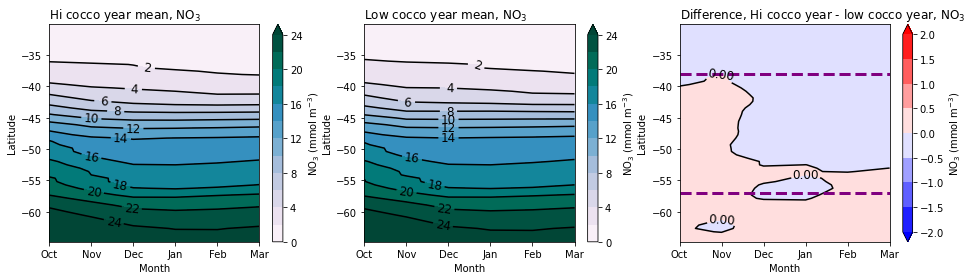

In [32]:
fig = plt.figure(figsize=(16,4))

### NO3
var = 'NO3'
levels = np.arange(0,25,2)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, NO$_3$',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, NO$_3$',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-2,2.5,0.5)

ax.set_title('Difference, Hi cocco year - low cocco year, NO$_3$',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38,linestyle='--',linewidth=3, color='purple')
ax.axhline(-57,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');


## Fe

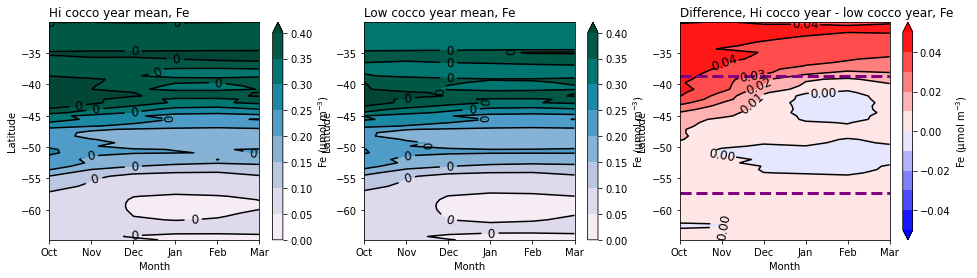

In [33]:
fig = plt.figure(figsize=(16,4))

var = 'Fe'
levels = np.arange(0,0.45,0.05)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, Fe',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, Fe',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-0.05,0.06,0.01)

ax.set_title('Difference, Hi cocco year - low cocco year, Fe',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


## TEMP

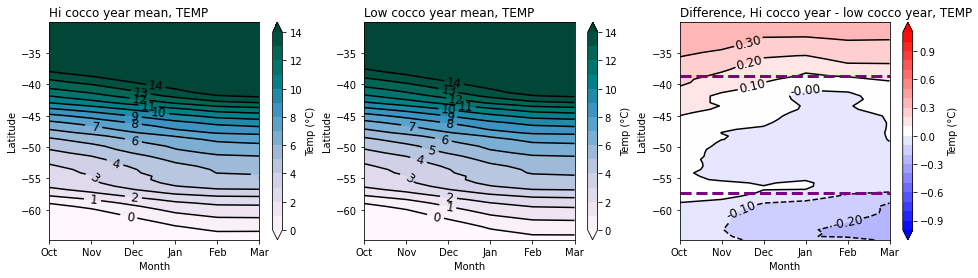

In [34]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'TEMP'
levels = np.arange(0,15,1)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, TEMP',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, TEMP',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-1,1.2,0.1)

ax.set_title('Difference, Hi cocco year - low cocco year, TEMP',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');


## HMXL

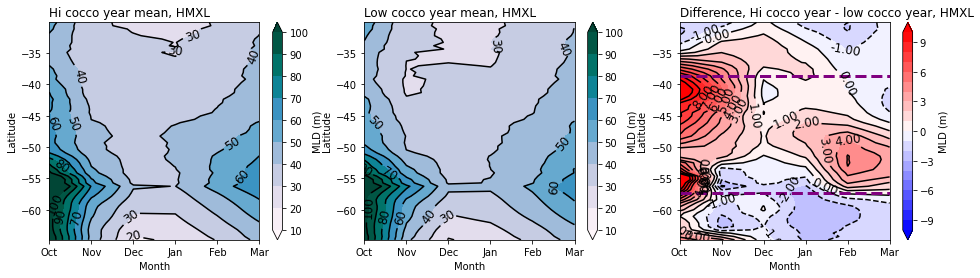

In [35]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'HMXL'
levels = np.arange(10,110,10)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, HMXL',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, HMXL',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-10,11,1)

ax.set_title('Difference, Hi cocco year - low cocco year, HMXL',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');


## IRON FLUX

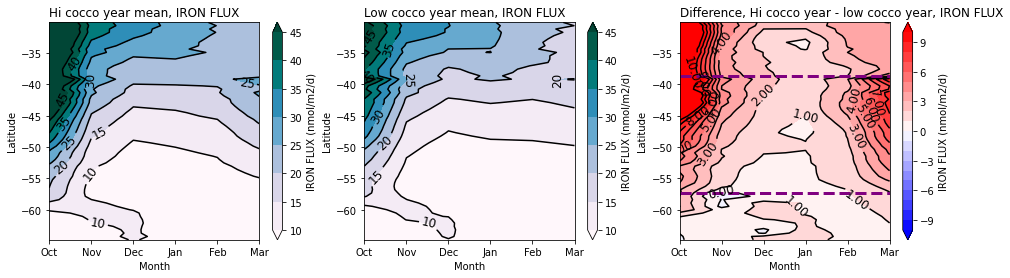

In [36]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'IRON_FLUX'
levels = np.arange(10,50,5)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, IRON FLUX',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, IRON FLUX',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-10,11,1)

ax.set_title('Difference, Hi cocco year - low cocco year, IRON FLUX',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');


## SW

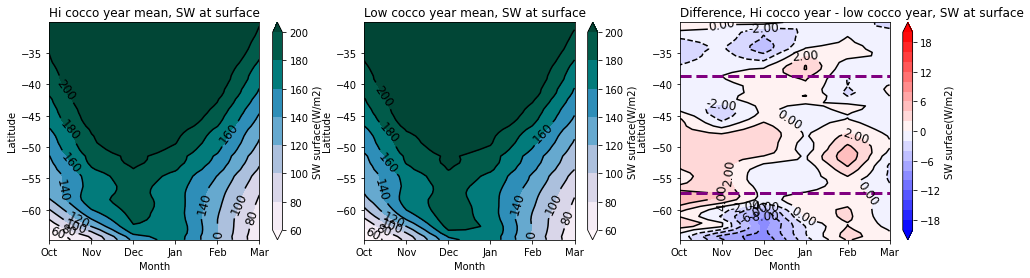

In [37]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'SHF_QSW'
levels = np.arange(60,220,20)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, SW at surface',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, SW at surface',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-20,22,2)

ax.set_title('Difference, Hi cocco year - low cocco year, SW at surface',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');


## Diatom carbon, a competition aspect?

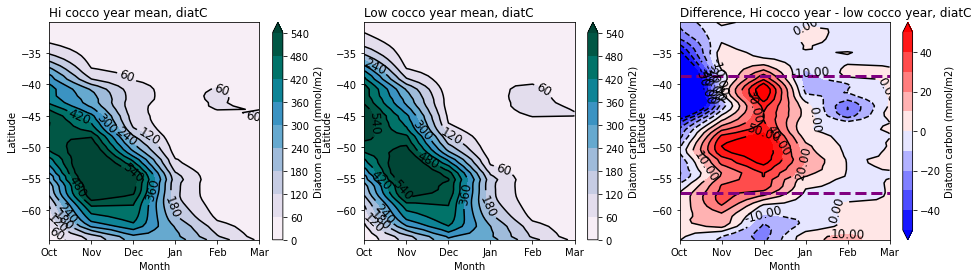

In [38]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'diatC'
levels = np.arange(0,600,60)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, diatC',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, diatC',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-50,60,10)

ax.set_title('Difference, Hi cocco year - low cocco year, diatC',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');


### Try using gridspec to arrange panels

In [39]:
import matplotlib.gridspec as gridspec

In [ ]:
### fig = plt.figure(figsize=(19, 12))
fig.suptitle('Region 1', x=0.48,y=0.92,color='dodgerblue',fontweight='bold', fontsize='14')
gs = gridspec.GridSpec(nrows=6, ncols=9, width_ratios=(1, 0.15, 1, 1,0.1, 1, 0.15, 1, 1))

################## row 1
### NO3
ax_no3_hi = plt.subplot(gs[0, 0])
ax_no3_lo = plt.subplot(gs[1, 0])
#ax_no3_cb = plt.subplot(gs[0:2, 1])
### NO3 diff
ax_no3_diff = plt.subplot(gs[0:2, 2:4])

### Fe
ax_fe_hi = plt.subplot(gs[0, 5])
ax_fe_lo = plt.subplot(gs[1, 5])
#ax_fe_cb = plt.subplot(gs[0:2, 5])
### Fe diff
ax_fe_diff = plt.subplot(gs[0:2, 7:9])


################## row 2
### Iron flux
ax_feflux_hi = plt.subplot(gs[2, 0])
ax_feflux_lo = plt.subplot(gs[3, 0])
#ax_feflux_cb = plt.subplot(gs[2:4, 1])
### iron flux diff
ax_feflux_diff = plt.subplot(gs[2:4, 2:4])

### SW
ax_sw_hi = plt.subplot(gs[2, 5])
ax_sw_lo = plt.subplot(gs[3, 5])
#ax_sw_cb = plt.subplot(gs[2:4, 5])
### SW diff
ax_sw_diff = plt.subplot(gs[2:4, 7:9])


################## row 3
### temp
ax_temp_hi = plt.subplot(gs[4, 0])
ax_temp_lo = plt.subplot(gs[5, 0])
#ax_temp_cb = plt.subplot(gs[4:6, 1])
### temp diff
ax_temp_diff = plt.subplot(gs[4:6, 2:4])

### MLD
ax_mld_hi = plt.subplot(gs[4, 5])
ax_mld_lo = plt.subplot(gs[5, 5])
#ax_mld_cb = plt.subplot(gs[4:6, 5])
### SW diff
ax_mld_diff = plt.subplot(gs[4:6, 7:9])




########################  NO3
var = 'NO3'
levels = np.arange(0,25,4)
cmap='PuBuGn'

ax_no3_hi.set_title('a) Hi cocco, NO$_3$ (mmol m$^{-3}$)',fontsize=11, x=0.5,y=1)
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc = ax_no3_hi.contourf(months2,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = ax_no3_hi.contour(months2,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax_no3_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');


ax_no3_lo.set_title('b) Low cocco, NO$_3$ (mmol m$^{-3}$)',fontsize=11, x=0.5,y=1)
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc = ax_no3_lo.contourf(months2,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = ax_no3_lo.contour(months2,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax_no3_lo.set(ylabel='Latitude') #xlabel='Month',

#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

######### colorbar for no3
#c_ax = fig.colorbar(pc, cax=ax_no3_cb, pad=1)


################# diff plot, adjust levels

levels = np.arange(-1,1.2,0.2)

ax_no3_diff.set_title('c) Hi - low cocco, ${\Delta}$NO$_3$',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_no3_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_no3_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_no3_diff.axhline(-38,linestyle='--',linewidth=3, color='purple')
ax_no3_diff.axhline(-57,linestyle='--',linewidth=3, color='purple')
#ax_no3_diff.set(xlabel='Month') #,ylabel='Latitude')
#ax_no3_diff.set_yticks([])
fig.colorbar(pc, ax=ax_no3_diff, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

################################################################### Fe

var = 'Fe'
levels = np.arange(0,0.5,0.1)
cmap='PuBuGn'


ax_fe_hi.set_title('d) Hi cocco, Fe (µmol m$^{-3}$)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_fe_hi.contourf(months2,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = ax_fe_hi.contour(months2,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


ax_fe_lo.set_title('e) Low cocco, Fe (µmol m$^{-3}$)',fontsize=11,  loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_fe_lo.contourf(months2,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = ax_fe_lo.contour(months2,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');

levels = np.arange(-0.05,0.06,0.01)

ax_fe_diff.set_title('f) Hi cocco - low cocco, ${\Delta}$Fe',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_fe_diff.contourf(months,lat,tmp.transpose()*1000, levels, cmap='bwr',extend='both')
contour = ax_fe_diff.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_fe_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_fe_diff.set(ylabel='Latitude') #, xlabel='Month',
fig.colorbar(pc, ax=ax_fe_diff, label='Fe (µmol m$^{-3}$)',extend='both');



###################################################### Iron flux

var = 'IRON_FLUX'
levels = np.arange(10,50,5)
cmap='PuBuGn'

ax_feflux_hi.set_title('g) Hi cocco, Iron flux (nmol m$^{-2}$ d$^{-1}$)',fontsize=11, x=0.4,y=1)
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_feflux_hi.contourf(months2,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = ax_feflux_hi.contour(months2,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_feflux_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

ax_feflux_lo.set_title('h) Low cocco, Iron flux (nmol m$^{-2}$ d$^{-1}$)',fontsize=11, x=0.4,y=1)
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_feflux_lo.contourf(months2,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = ax_feflux_lo.contour(months2,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_feflux_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

levels = np.arange(-10,11,1)
ax_feflux_diff.set_title('i) Hi cocco - low cocco, ${\Delta}$Iron flux',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_feflux_diff.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap='bwr',extend='both')
contour = ax_feflux_diff.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_feflux_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_feflux_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
#ax_feflux_diff.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, ax=ax_feflux_diff, label='Iron flux (nmol m$^{-2}$ d$^{-1}$)',extend='both');

############################################################################# SW

var = 'SHF_QSW'
levels = np.arange(60,240,20)
cmap='PuBuGn'

ax_sw_hi.set_title('j) Hi cocco, SW (W $^{-2}$)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_sw_hi.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_sw_hi.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_sw_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

ax_sw_lo.set_title('k) Low cocco, SW (W $^{-2}$)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_sw_lo.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_sw_lo.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_sw_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

levels = np.arange(-10,12,2)

ax_sw_diff.set_title('l) Hi cocco year - low cocco, ${\Delta}$SW',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_sw_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_sw_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_sw_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_sw_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_sw_diff.set(ylabel='Latitude') #xlabel='Month'
fig.colorbar(pc, ax=ax_sw_diff, label='Shortwave at surface (W $^{-2}$)',extend='both');



############################################################################# TEMP

var = 'TEMP'
levels = np.arange(0,15,1)
cmap='PuBuGn'

ax_temp_hi.set_title('m) Hi cocco, Temp (°C)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_temp_hi.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_temp_hi.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_temp_hi.set(ylabel='Latitude') #xlabel='Month',
#fig.colorbar(pc, label='Temp (°C)',extend='both');

ax_temp_lo.set_title('n) Low cocco, Temp (°C)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_temp_lo.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_temp_lo.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_temp_lo.set(ylabel='Latitude') #xlabel='Month',
#fig.colorbar(pc, label='Temp (°C)',extend='both');



################# diff plot, adjust levels
levels = np.arange(-1,1.2,0.1)

ax_temp_diff.set_title('o) Hi cocco - low cocco, ${\Delta}$Temp',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_temp_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_temp_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_temp_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_temp_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
#ax_temp_diff.set(ylabel='Latitude') #xlabel='Month'
fig.colorbar(pc, ax=ax_temp_diff, label='Temp (°C)',extend='both');

###################################################################### MLD

var = 'HMXL'
levels = np.arange(10,110,10)
cmap='PuBuGn'

ax_mld_hi.set_title('p) Hi cocco, MLD (m)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat =lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_mld_hi.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = ax_mld_hi.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_mld_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='MLD (m)',extend='both');

ax_mld_lo.set_title('q) Low cocco, MLD (m)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_mld_lo.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = ax_mld_lo.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_mld_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='MLD (m)',extend='both');



################# diff plot, adjust levels
levels = np.arange(-12,14,2)

ax_mld_diff.set_title('r) Hi cocco - low cocco, ${\Delta}$MLD (m)',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp2 = lo_cocco_ts_reg1[var].where(lats_transect_reg1<-30,drop=True).where(lats_trimmed_reg1>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg1.where(lats_trimmed_reg1>-65,drop=True)
pc=ax_mld_diff.contourf(months,lat,tmp.transpose()*0.01, levels, cmap='bwr',extend='both')
contour = ax_mld_diff.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_mld_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_mld_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_mld_diff.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, ax=ax_mld_diff, label='MLD (m)',extend='both');


fig.subplots_adjust(wspace=0.2,hspace=0.5)

fig.savefig('/glade/work/kristenk/figs/hi-lo-cocco-hovmoellers_Reg1.png', bbox_inches='tight', dpi=300, format='png');

# REGION 2

## NO3

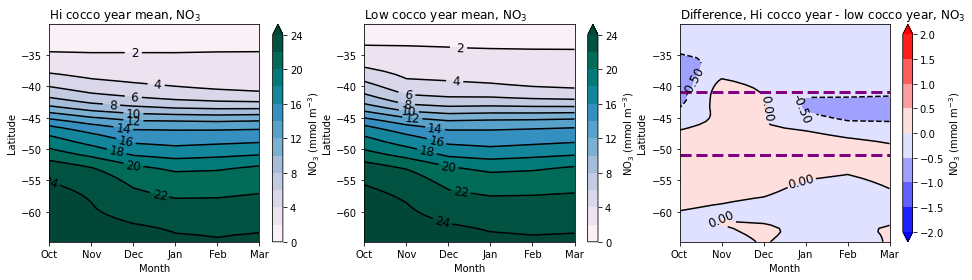

In [52]:
fig = plt.figure(figsize=(16,4))

### NO3
var = 'NO3'
levels = np.arange(0,25,2)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, NO$_3$',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, NO$_3$',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-2,2.5,0.5)

ax.set_title('Difference, Hi cocco year - low cocco year, NO$_3$',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-40.8,linestyle='--',linewidth=3, color='purple')
ax.axhline(-51,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');


## Fe

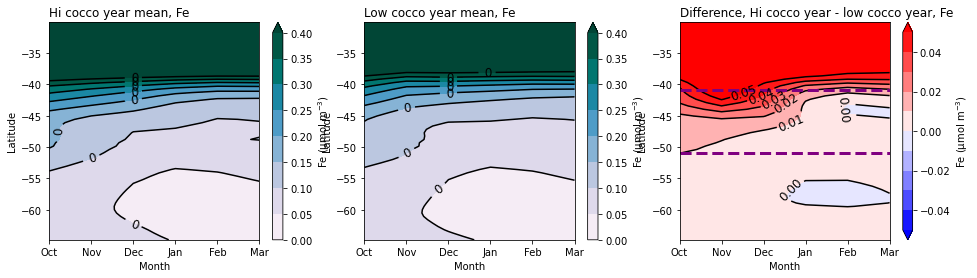

In [53]:
fig = plt.figure(figsize=(16,4))

var = 'Fe'
levels = np.arange(0,0.45,0.05)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, Fe',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, Fe',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-0.05,0.06,0.01)

ax.set_title('Difference, Hi cocco year - low cocco year, Fe',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-40.8,linestyle='--',linewidth=3, color='purple')
ax.axhline(-51,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


## TEMP

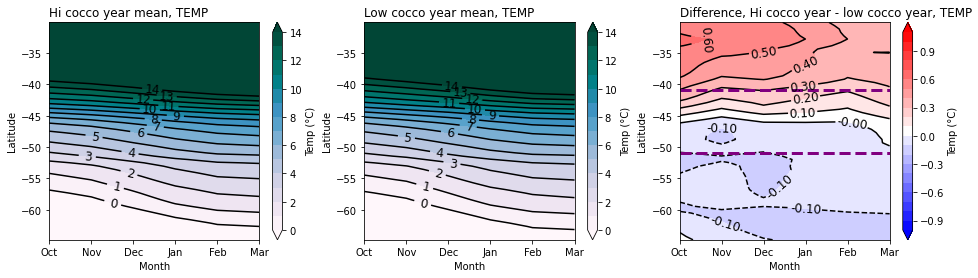

In [54]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'TEMP'
levels = np.arange(0,15,1)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, TEMP',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, TEMP',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-1,1.2,0.1)

ax.set_title('Difference, Hi cocco year - low cocco year, TEMP',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-40.8,linestyle='--',linewidth=3, color='purple')
ax.axhline(-51,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');


## HMXL

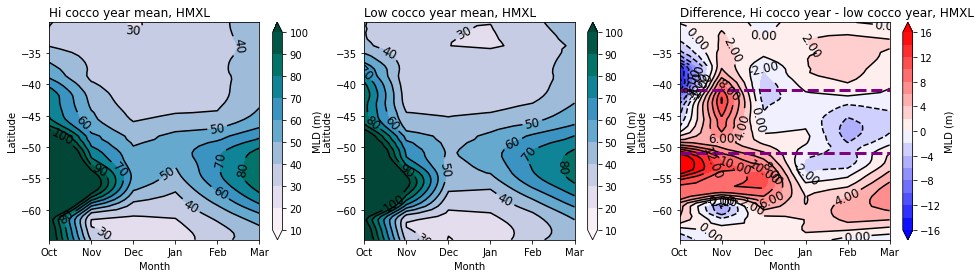

In [55]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'HMXL'
levels = np.arange(10,110,10)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, HMXL',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, HMXL',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-16,17,2)

ax.set_title('Difference, Hi cocco year - low cocco year, HMXL',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-40.8,linestyle='--',linewidth=3, color='purple')
ax.axhline(-51,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');


## IRON FLUX

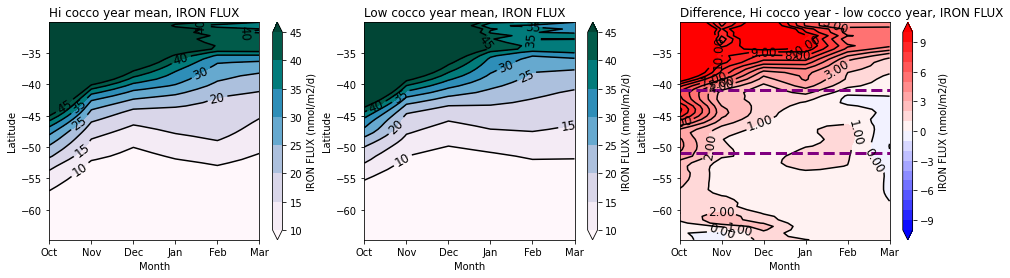

In [56]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'IRON_FLUX'
levels = np.arange(10,50,5)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, IRON FLUX',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, IRON FLUX',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-10,11,1)

ax.set_title('Difference, Hi cocco year - low cocco year, IRON FLUX',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-40.8,linestyle='--',linewidth=3, color='purple')
ax.axhline(-51,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');


## SW

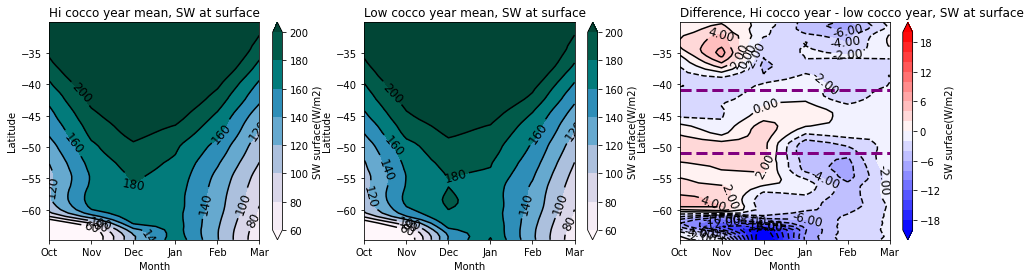

In [57]:
fig = plt.figure(figsize=(16,4))

var = 'SHF_QSW'
levels = np.arange(60,220,20)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, SW at surface',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, SW at surface',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-20,22,2)

ax.set_title('Difference, Hi cocco year - low cocco year, SW at surface',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-40.8,linestyle='--',linewidth=3, color='purple')
ax.axhline(-51,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');


## Diatom carbon

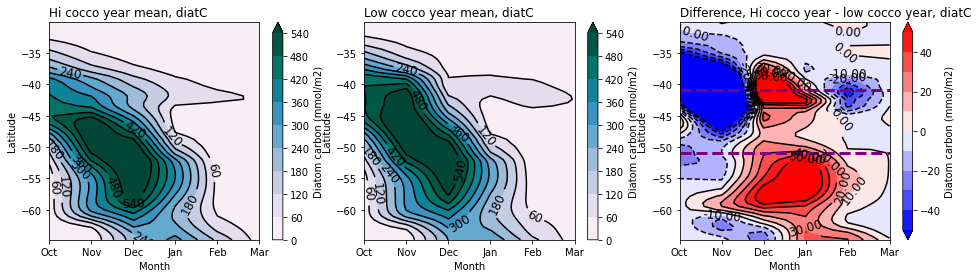

In [58]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'diatC'
levels = np.arange(0,600,60)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, diatC',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, diatC',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-50,60,10)

ax.set_title('Difference, Hi cocco year - low cocco year, diatC',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-40.8,linestyle='--',linewidth=3, color='purple')
ax.axhline(-51,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');


### Altogether now

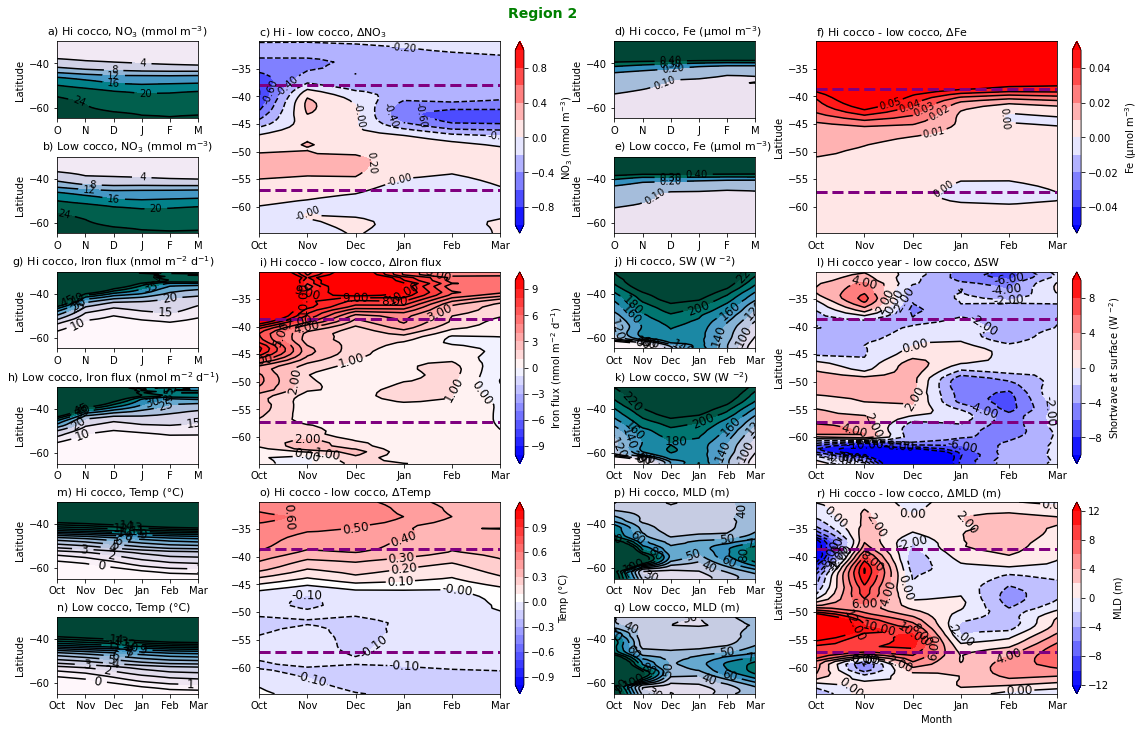

In [94]:
fig = plt.figure(figsize=(19, 12))
fig.suptitle('Region 2', x=0.48,y=0.92,color='green',fontweight='bold', fontsize='14')
gs = gridspec.GridSpec(nrows=6, ncols=9, width_ratios=(1, 0.15, 1, 1,0.1, 1, 0.15, 1, 1))

################## row 1
### NO3
ax_no3_hi = plt.subplot(gs[0, 0])
ax_no3_lo = plt.subplot(gs[1, 0])
#ax_no3_cb = plt.subplot(gs[0:2, 1])
### NO3 diff
ax_no3_diff = plt.subplot(gs[0:2, 2:4])

### Fe
ax_fe_hi = plt.subplot(gs[0, 5])
ax_fe_lo = plt.subplot(gs[1, 5])
#ax_fe_cb = plt.subplot(gs[0:2, 5])
### Fe diff
ax_fe_diff = plt.subplot(gs[0:2, 7:9])


################## row 2
### Iron flux
ax_feflux_hi = plt.subplot(gs[2, 0])
ax_feflux_lo = plt.subplot(gs[3, 0])
#ax_feflux_cb = plt.subplot(gs[2:4, 1])
### iron flux diff
ax_feflux_diff = plt.subplot(gs[2:4, 2:4])

### SW
ax_sw_hi = plt.subplot(gs[2, 5])
ax_sw_lo = plt.subplot(gs[3, 5])
#ax_sw_cb = plt.subplot(gs[2:4, 5])
### SW diff
ax_sw_diff = plt.subplot(gs[2:4, 7:9])


################## row 3
### temp
ax_temp_hi = plt.subplot(gs[4, 0])
ax_temp_lo = plt.subplot(gs[5, 0])
#ax_temp_cb = plt.subplot(gs[4:6, 1])
### temp diff
ax_temp_diff = plt.subplot(gs[4:6, 2:4])

### MLD
ax_mld_hi = plt.subplot(gs[4, 5])
ax_mld_lo = plt.subplot(gs[5, 5])
#ax_mld_cb = plt.subplot(gs[4:6, 5])
### SW diff
ax_mld_diff = plt.subplot(gs[4:6, 7:9])




########################  NO3
var = 'NO3'
levels = np.arange(0,25,4)
cmap='PuBuGn'

ax_no3_hi.set_title('a) Hi cocco, NO$_3$ (mmol m$^{-3}$)',fontsize=11, x=0.5,y=1)
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc = ax_no3_hi.contourf(months2,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = ax_no3_hi.contour(months2,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax_no3_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');


ax_no3_lo.set_title('b) Low cocco, NO$_3$ (mmol m$^{-3}$)',fontsize=11, x=0.5,y=1)
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc = ax_no3_lo.contourf(months2,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = ax_no3_lo.contour(months2,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax_no3_lo.set(ylabel='Latitude') #xlabel='Month',

#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

######### colorbar for no3
#c_ax = fig.colorbar(pc, cax=ax_no3_cb, pad=1)


################# diff plot, adjust levels

levels = np.arange(-1,1.2,0.2)

ax_no3_diff.set_title('c) Hi - low cocco, ${\Delta}$NO$_3$',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_no3_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_no3_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_no3_diff.axhline(-38,linestyle='--',linewidth=3, color='purple')
ax_no3_diff.axhline(-57,linestyle='--',linewidth=3, color='purple')
#ax_no3_diff.set(xlabel='Month') #,ylabel='Latitude')
#ax_no3_diff.set_yticks([])
fig.colorbar(pc, ax=ax_no3_diff, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

################################################################### Fe

var = 'Fe'
levels = np.arange(0,0.5,0.1)
cmap='PuBuGn'


ax_fe_hi.set_title('d) Hi cocco, Fe (µmol m$^{-3}$)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_fe_hi.contourf(months2,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = ax_fe_hi.contour(months2,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


ax_fe_lo.set_title('e) Low cocco, Fe (µmol m$^{-3}$)',fontsize=11,  loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_fe_lo.contourf(months2,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = ax_fe_lo.contour(months2,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');

levels = np.arange(-0.05,0.06,0.01)

ax_fe_diff.set_title('f) Hi cocco - low cocco, ${\Delta}$Fe',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_fe_diff.contourf(months,lat,tmp.transpose()*1000, levels, cmap='bwr',extend='both')
contour = ax_fe_diff.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_fe_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_fe_diff.set(ylabel='Latitude') #, xlabel='Month',
fig.colorbar(pc, ax=ax_fe_diff, label='Fe (µmol m$^{-3}$)',extend='both');



###################################################### Iron flux

var = 'IRON_FLUX'
levels = np.arange(10,50,5)
cmap='PuBuGn'

ax_feflux_hi.set_title('g) Hi cocco, Iron flux (nmol m$^{-2}$ d$^{-1}$)',fontsize=11, x=0.4,y=1)
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_feflux_hi.contourf(months2,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = ax_feflux_hi.contour(months2,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_feflux_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

ax_feflux_lo.set_title('h) Low cocco, Iron flux (nmol m$^{-2}$ d$^{-1}$)',fontsize=11, x=0.4,y=1)
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_feflux_lo.contourf(months2,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = ax_feflux_lo.contour(months2,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_feflux_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

levels = np.arange(-10,11,1)
ax_feflux_diff.set_title('i) Hi cocco - low cocco, ${\Delta}$Iron flux',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_feflux_diff.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap='bwr',extend='both')
contour = ax_feflux_diff.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_feflux_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_feflux_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
#ax_feflux_diff.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, ax=ax_feflux_diff, label='Iron flux (nmol m$^{-2}$ d$^{-1}$)',extend='both');

############################################################################# SW

var = 'SHF_QSW'
levels = np.arange(60,240,20)
cmap='PuBuGn'

ax_sw_hi.set_title('j) Hi cocco, SW (W $^{-2}$)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_sw_hi.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_sw_hi.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_sw_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

ax_sw_lo.set_title('k) Low cocco, SW (W $^{-2}$)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_sw_lo.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_sw_lo.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_sw_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

levels = np.arange(-10,12,2)

ax_sw_diff.set_title('l) Hi cocco year - low cocco, ${\Delta}$SW',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_sw_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_sw_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_sw_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_sw_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_sw_diff.set(ylabel='Latitude') #xlabel='Month'
fig.colorbar(pc, ax=ax_sw_diff, label='Shortwave at surface (W $^{-2}$)',extend='both');



############################################################################# TEMP

var = 'TEMP'
levels = np.arange(0,15,1)
cmap='PuBuGn'

ax_temp_hi.set_title('m) Hi cocco, Temp (°C)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_temp_hi.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_temp_hi.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_temp_hi.set(ylabel='Latitude') #xlabel='Month',
#fig.colorbar(pc, label='Temp (°C)',extend='both');

ax_temp_lo.set_title('n) Low cocco, Temp (°C)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_temp_lo.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_temp_lo.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_temp_lo.set(ylabel='Latitude') #xlabel='Month',
#fig.colorbar(pc, label='Temp (°C)',extend='both');



################# diff plot, adjust levels
levels = np.arange(-1,1.2,0.1)

ax_temp_diff.set_title('o) Hi cocco - low cocco, ${\Delta}$Temp',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_temp_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_temp_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_temp_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_temp_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
#ax_temp_diff.set(ylabel='Latitude') #xlabel='Month'
fig.colorbar(pc, ax=ax_temp_diff, label='Temp (°C)',extend='both');

###################################################################### MLD

var = 'HMXL'
levels = np.arange(10,110,10)
cmap='PuBuGn'

ax_mld_hi.set_title('p) Hi cocco, MLD (m)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat =lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_mld_hi.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = ax_mld_hi.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_mld_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='MLD (m)',extend='both');

ax_mld_lo.set_title('q) Low cocco, MLD (m)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_mld_lo.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = ax_mld_lo.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_mld_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='MLD (m)',extend='both');



################# diff plot, adjust levels
levels = np.arange(-12,14,2)

ax_mld_diff.set_title('r) Hi cocco - low cocco, ${\Delta}$MLD (m)',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp2 = lo_cocco_ts_reg2[var].where(lats_transect_reg2<-30,drop=True).where(lats_trimmed_reg2>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg2.where(lats_trimmed_reg2>-65,drop=True)
pc=ax_mld_diff.contourf(months,lat,tmp.transpose()*0.01, levels, cmap='bwr',extend='both')
contour = ax_mld_diff.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_mld_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_mld_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_mld_diff.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, ax=ax_mld_diff, label='MLD (m)',extend='both');


fig.subplots_adjust(wspace=0.2,hspace=0.5)

fig.savefig('/glade/work/kristenk/figs/hi-lo-cocco-hovmoellers_Reg2.png', bbox_inches='tight', dpi=300, format='png');

# REGION 3

## NO3

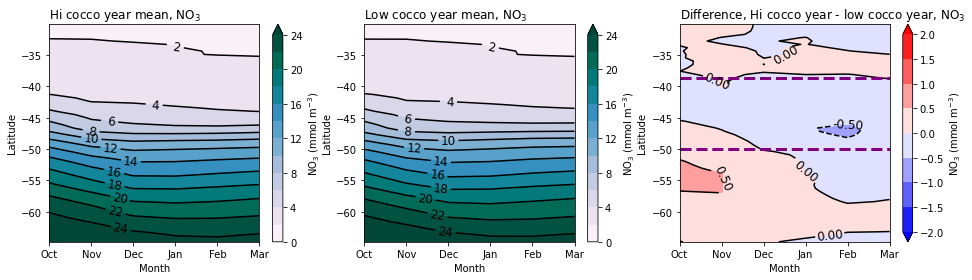

In [59]:
fig = plt.figure(figsize=(16,4))

### NO3
var = 'NO3'
levels = np.arange(0,25,2)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, NO$_3$',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, NO$_3$',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-2,2.5,0.5)

ax.set_title('Difference, Hi cocco year - low cocco year, NO$_3$',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-50,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');


## Fe

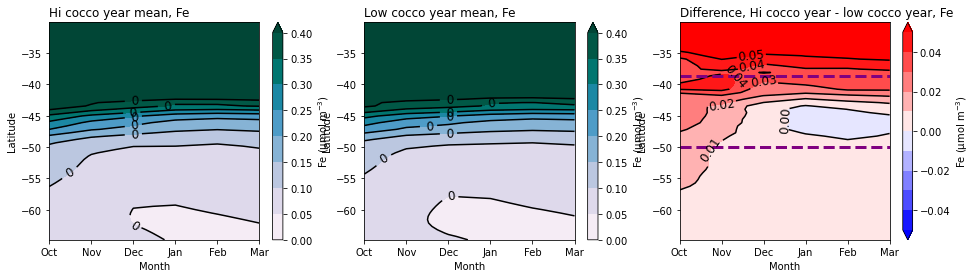

In [60]:
fig = plt.figure(figsize=(16,4))

var = 'Fe'
levels = np.arange(0,0.45,0.05)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, Fe',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, Fe',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-0.05,0.06,0.01)

ax.set_title('Difference, Hi cocco year - low cocco year, Fe',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*1000, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-50,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


## TEMP

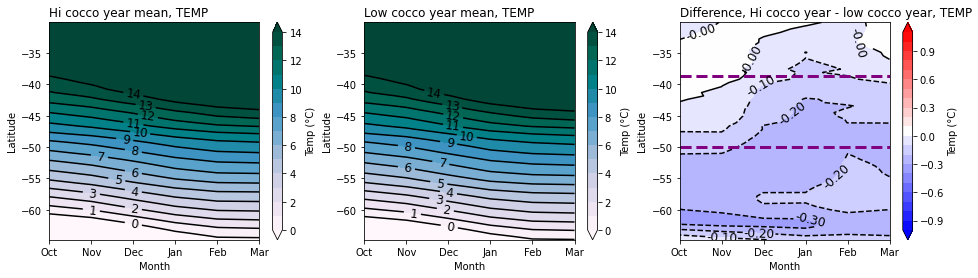

In [61]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'TEMP'
levels = np.arange(0,15,1)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, TEMP',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, TEMP',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-1,1.2,0.1)

ax.set_title('Difference, Hi cocco year - low cocco year, TEMP',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-50,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Temp (°C)',extend='both');


## HMXL

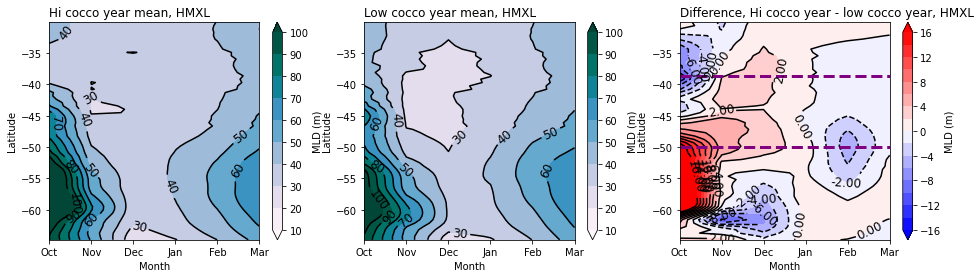

In [62]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'HMXL'
levels = np.arange(10,110,10)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, HMXL',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, HMXL',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-16,17,2)

ax.set_title('Difference, Hi cocco year - low cocco year, HMXL',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*0.01, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-50,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='MLD (m)',extend='both');


## IRON FLUX

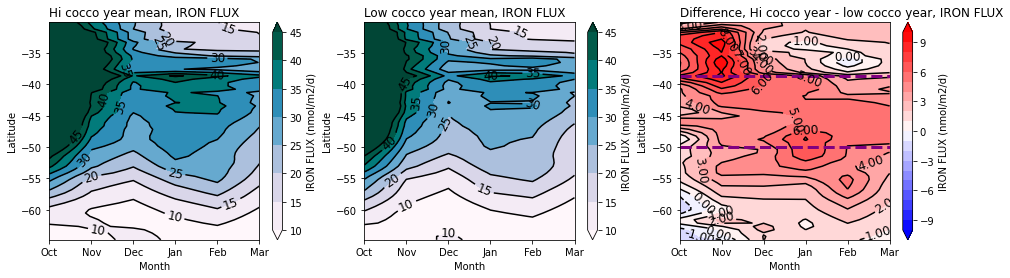

In [63]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'IRON_FLUX'
levels = np.arange(10,50,5)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, IRON FLUX',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, IRON FLUX',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-10,11,1)

ax.set_title('Difference, Hi cocco year - low cocco year, IRON FLUX',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-50,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');


## SW

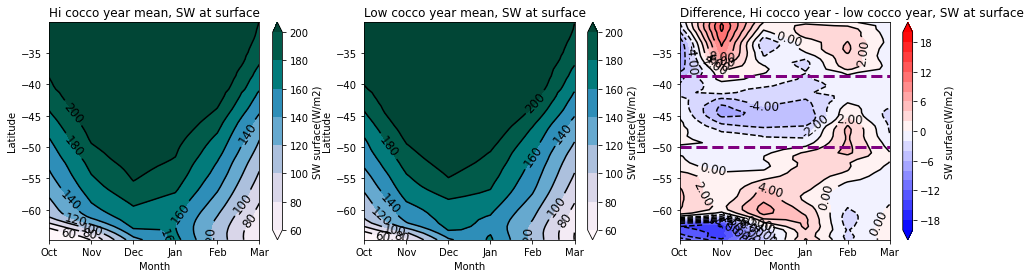

In [64]:
fig = plt.figure(figsize=(16,4))

var = 'SHF_QSW'
levels = np.arange(60,220,20)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, SW at surface',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, SW at surface',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-20,22,2)

ax.set_title('Difference, Hi cocco year - low cocco year, SW at surface',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-50,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='SW surface(W/m2)',extend='both');


## Diatom carbon

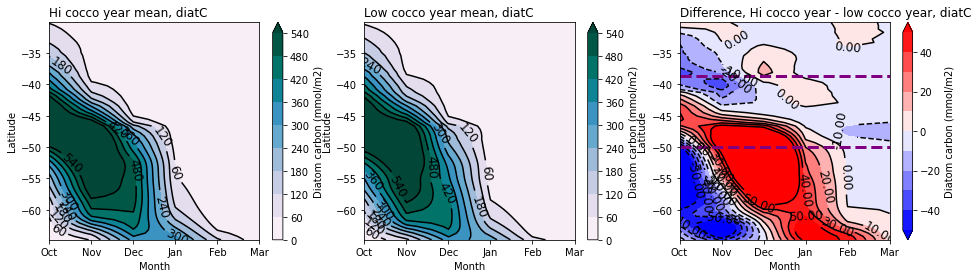

In [65]:
fig = plt.figure(figsize=(16,4))

### TEMP
var = 'diatC'
levels = np.arange(0,600,60)
cmap='PuBuGn'

ax = fig.add_subplot(1,3,1)
ax.set_title('Hi cocco year mean, diatC',fontsize=12, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');

ax = fig.add_subplot(1,3,2)
ax.set_title('Low cocco year mean, diatC',fontsize=12, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');



################# diff plot, adjust levels
ax = fig.add_subplot(1,3,3)
levels = np.arange(-50,60,10)

ax.set_title('Difference, Hi cocco year - low cocco year, diatC',fontsize=12, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = plt.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax.axhline(-50,linestyle='--',linewidth=3, color='purple')
ax.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, label='Diatom carbon (mmol/m2)',extend='both');


### All together now for region 3

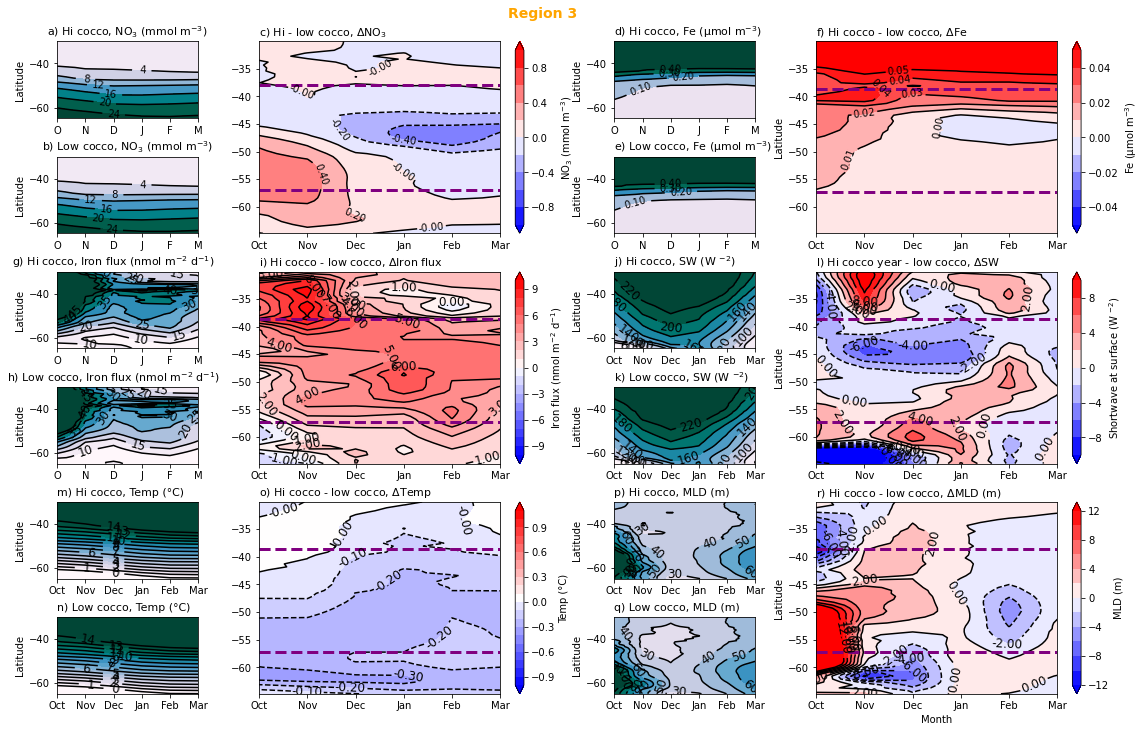

In [96]:
fig = plt.figure(figsize=(19, 12))
fig.suptitle('Region 3', x=0.48,y=0.92,color='orange',fontweight='bold', fontsize='14')
gs = gridspec.GridSpec(nrows=6, ncols=9, width_ratios=(1, 0.15, 1, 1,0.1, 1, 0.15, 1, 1))

################## row 1
### NO3
ax_no3_hi = plt.subplot(gs[0, 0])
ax_no3_lo = plt.subplot(gs[1, 0])
#ax_no3_cb = plt.subplot(gs[0:2, 1])
### NO3 diff
ax_no3_diff = plt.subplot(gs[0:2, 2:4])

### Fe
ax_fe_hi = plt.subplot(gs[0, 5])
ax_fe_lo = plt.subplot(gs[1, 5])
#ax_fe_cb = plt.subplot(gs[0:2, 5])
### Fe diff
ax_fe_diff = plt.subplot(gs[0:2, 7:9])


################## row 2
### Iron flux
ax_feflux_hi = plt.subplot(gs[2, 0])
ax_feflux_lo = plt.subplot(gs[3, 0])
#ax_feflux_cb = plt.subplot(gs[2:4, 1])
### iron flux diff
ax_feflux_diff = plt.subplot(gs[2:4, 2:4])

### SW
ax_sw_hi = plt.subplot(gs[2, 5])
ax_sw_lo = plt.subplot(gs[3, 5])
#ax_sw_cb = plt.subplot(gs[2:4, 5])
### SW diff
ax_sw_diff = plt.subplot(gs[2:4, 7:9])


################## row 3
### temp
ax_temp_hi = plt.subplot(gs[4, 0])
ax_temp_lo = plt.subplot(gs[5, 0])
#ax_temp_cb = plt.subplot(gs[4:6, 1])
### temp diff
ax_temp_diff = plt.subplot(gs[4:6, 2:4])

### MLD
ax_mld_hi = plt.subplot(gs[4, 5])
ax_mld_lo = plt.subplot(gs[5, 5])
#ax_mld_cb = plt.subplot(gs[4:6, 5])
### SW diff
ax_mld_diff = plt.subplot(gs[4:6, 7:9])




########################  NO3
var = 'NO3'
levels = np.arange(0,25,4)
cmap='PuBuGn'

ax_no3_hi.set_title('a) Hi cocco, NO$_3$ (mmol m$^{-3}$)',fontsize=11, x=0.5,y=1)
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc = ax_no3_hi.contourf(months2,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = ax_no3_hi.contour(months2,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax_no3_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');


ax_no3_lo.set_title('b) Low cocco, NO$_3$ (mmol m$^{-3}$)',fontsize=11, x=0.5,y=1)
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc = ax_no3_lo.contourf(months2,lat,tmp.transpose(), levels, cmap=cmap,extend='max')
contour = ax_no3_lo.contour(months2,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=10)
ax_no3_lo.set(ylabel='Latitude') #xlabel='Month',

#fig.colorbar(pc, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

######### colorbar for no3
#c_ax = fig.colorbar(pc, cax=ax_no3_cb, pad=1)


################# diff plot, adjust levels

levels = np.arange(-1,1.2,0.2)

ax_no3_diff.set_title('c) Hi - low cocco, ${\Delta}$NO$_3$',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_no3_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_no3_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_no3_diff.axhline(-38,linestyle='--',linewidth=3, color='purple')
ax_no3_diff.axhline(-57,linestyle='--',linewidth=3, color='purple')
#ax_no3_diff.set(xlabel='Month') #,ylabel='Latitude')
#ax_no3_diff.set_yticks([])
fig.colorbar(pc, ax=ax_no3_diff, label='NO$_3$ (mmol m$^{-3}$)',extend='both');

################################################################### Fe

var = 'Fe'
levels = np.arange(0,0.5,0.1)
cmap='PuBuGn'


ax_fe_hi.set_title('d) Hi cocco, Fe (µmol m$^{-3}$)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_fe_hi.contourf(months2,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = ax_fe_hi.contour(months2,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');


ax_fe_lo.set_title('e) Low cocco, Fe (µmol m$^{-3}$)',fontsize=11,  loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_fe_lo.contourf(months2,lat,tmp.transpose()*1000, levels, cmap=cmap,extend='max')
contour = ax_fe_lo.contour(months2,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='Fe (µmol m$^{-3}$)',extend='both');

levels = np.arange(-0.05,0.06,0.01)

ax_fe_diff.set_title('f) Hi cocco - low cocco, ${\Delta}$Fe',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_fe_diff.contourf(months,lat,tmp.transpose()*1000, levels, cmap='bwr',extend='both')
contour = ax_fe_diff.contour(months,lat,tmp.transpose()*1000, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=10)
ax_fe_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_fe_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_fe_diff.set(ylabel='Latitude') #, xlabel='Month',
fig.colorbar(pc, ax=ax_fe_diff, label='Fe (µmol m$^{-3}$)',extend='both');



###################################################### Iron flux

var = 'IRON_FLUX'
levels = np.arange(10,50,5)
cmap='PuBuGn'

ax_feflux_hi.set_title('g) Hi cocco, Iron flux (nmol m$^{-2}$ d$^{-1}$)',fontsize=11, x=0.4,y=1)
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_feflux_hi.contourf(months2,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = ax_feflux_hi.contour(months2,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_feflux_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

ax_feflux_lo.set_title('h) Low cocco, Iron flux (nmol m$^{-2}$ d$^{-1}$)',fontsize=11, x=0.4,y=1)
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_feflux_lo.contourf(months2,lat,tmp.transpose()*86400*1e6, levels, cmap=cmap,extend='both')
contour = ax_feflux_lo.contour(months2,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_feflux_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='IRON FLUX (nmol/m2/d)',extend='both');

levels = np.arange(-10,11,1)
ax_feflux_diff.set_title('i) Hi cocco - low cocco, ${\Delta}$Iron flux',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_feflux_diff.contourf(months,lat,tmp.transpose()*86400*1e6, levels, cmap='bwr',extend='both')
contour = ax_feflux_diff.contour(months,lat,tmp.transpose()*86400*1e6, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_feflux_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_feflux_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
#ax_feflux_diff.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, ax=ax_feflux_diff, label='Iron flux (nmol m$^{-2}$ d$^{-1}$)',extend='both');

############################################################################# SW

var = 'SHF_QSW'
levels = np.arange(60,240,20)
cmap='PuBuGn'

ax_sw_hi.set_title('j) Hi cocco, SW (W $^{-2}$)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_sw_hi.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_sw_hi.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_sw_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

ax_sw_lo.set_title('k) Low cocco, SW (W $^{-2}$)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_sw_lo.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_sw_lo.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_sw_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='SW surface(W/m2)',extend='both');

levels = np.arange(-10,12,2)

ax_sw_diff.set_title('l) Hi cocco year - low cocco, ${\Delta}$SW',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_sw_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_sw_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_sw_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_sw_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_sw_diff.set(ylabel='Latitude') #xlabel='Month'
fig.colorbar(pc, ax=ax_sw_diff, label='Shortwave at surface (W $^{-2}$)',extend='both');



############################################################################# TEMP

var = 'TEMP'
levels = np.arange(0,15,1)
cmap='PuBuGn'

ax_temp_hi.set_title('m) Hi cocco, Temp (°C)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_temp_hi.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_temp_hi.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_temp_hi.set(ylabel='Latitude') #xlabel='Month',
#fig.colorbar(pc, label='Temp (°C)',extend='both');

ax_temp_lo.set_title('n) Low cocco, Temp (°C)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_temp_lo.contourf(months,lat,tmp.transpose(), levels, cmap=cmap,extend='both')
contour = ax_temp_lo.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_temp_lo.set(ylabel='Latitude') #xlabel='Month',
#fig.colorbar(pc, label='Temp (°C)',extend='both');



################# diff plot, adjust levels
levels = np.arange(-1,1.2,0.1)

ax_temp_diff.set_title('o) Hi cocco - low cocco, ${\Delta}$Temp',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_temp_diff.contourf(months,lat,tmp.transpose(), levels, cmap='bwr',extend='both')
contour = ax_temp_diff.contour(months,lat,tmp.transpose(), levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_temp_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_temp_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
#ax_temp_diff.set(ylabel='Latitude') #xlabel='Month'
fig.colorbar(pc, ax=ax_temp_diff, label='Temp (°C)',extend='both');

###################################################################### MLD

var = 'HMXL'
levels = np.arange(10,110,10)
cmap='PuBuGn'

ax_mld_hi.set_title('p) Hi cocco, MLD (m)',fontsize=11, loc='left')
tmp = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat =lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_mld_hi.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = ax_mld_hi.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_mld_hi.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='MLD (m)',extend='both');

ax_mld_lo.set_title('q) Low cocco, MLD (m)',fontsize=11, loc='left')
tmp = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_mld_lo.contourf(months,lat,tmp.transpose()*0.01, levels, cmap=cmap,extend='both')
contour = ax_mld_lo.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.0f', fontsize=12)
ax_mld_lo.set(ylabel='Latitude') #xlabel='Month'
#fig.colorbar(pc, label='MLD (m)',extend='both');



################# diff plot, adjust levels
levels = np.arange(-12,14,2)

ax_mld_diff.set_title('r) Hi cocco - low cocco, ${\Delta}$MLD (m)',fontsize=11, loc='left')
tmp1 = hi_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp2 = lo_cocco_ts_reg3[var].where(lats_transect_reg3<-30,drop=True).where(lats_trimmed_reg3>-65,drop=True)
tmp = tmp1 -tmp2
lat = lats_trimmed_reg3.where(lats_trimmed_reg3>-65,drop=True)
pc=ax_mld_diff.contourf(months,lat,tmp.transpose()*0.01, levels, cmap='bwr',extend='both')
contour = ax_mld_diff.contour(months,lat,tmp.transpose()*0.01, levels, colors='k')
plt.clabel(contour, colors = 'k', fmt = '%2.2f', fontsize=12)
ax_mld_diff.axhline(-38.6,linestyle='--',linewidth=3, color='purple')
ax_mld_diff.axhline(-57.3,linestyle='--',linewidth=3, color='purple')
ax_mld_diff.set(xlabel='Month',ylabel='Latitude') #, xlabel='time (simulation years)')
fig.colorbar(pc, ax=ax_mld_diff, label='MLD (m)',extend='both');


fig.subplots_adjust(wspace=0.2,hspace=0.5)

fig.savefig('/glade/work/kristenk/figs/hi-lo-cocco-hovmoellers_Reg3.png', bbox_inches='tight', dpi=300, format='png');